# Matplotlib and pylab inline

In [1]:
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## Add path .. to make relative import

In [2]:
import sys

sys.path.insert(0, '..')

# Import libraries

In [3]:
import os
import cv2 as cv
import matplotlib.pyplot as plt

from matplotlib import rcParams
from src.preparation.reading import *
from src.processing.standardization import standardize_image
from src.processing.preprocessing import preproc_image
from src.processing.mask_and_contour import get_mask
from src.processing.noise import get_gradient, avg_grad, norm_vector
from pandas import DataFrame
from itertools import combinations as comb

rcParams["figure.dpi"] = 100
rcParams["figure.figsize"] = (4, 5)
rcParams["image.cmap"] = "gray"

## Read image

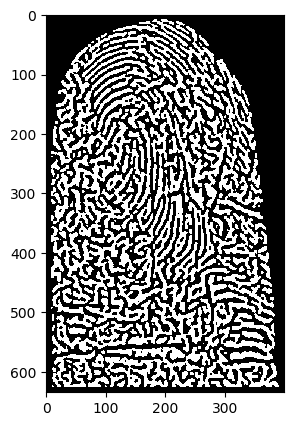

In [4]:
im = read_random_image(RAW_FILE_PATH_BADIM_NOISE)
std_im = standardize_image(im)
prep_im = preproc_image(std_im)


plt.imshow(prep_im)
plt.show()

# Get ready function of getting paired gradient

In [5]:
def get_pair_scalar_product_distribution(im, ksize=(17, 57)):
    
    dx, dy = get_gradient(im)
    
    dx_avg1, dy_avg1 = avg_grad(dx, dy, ksize[0])
    dx_avg2, dy_avg2 = avg_grad(dx, dy, ksize[1])
    
    mask0 = get_mask(im, with_ench=False) == 255
    mask1 = np.sqrt(dx_avg1*dx_avg1 + dy_avg1*dy_avg1) >  0.5
    mask2 = np.sqrt(dx_avg2*dx_avg2 + dy_avg2*dy_avg2) >  0.5
    
    mask = mask0 & mask1 & mask2
    
    dx_avg1, dy_avg1 = norm_vector(dx_avg1, dy_avg1)
    dx_avg2, dy_avg2 = norm_vector(dx_avg2, dy_avg2)
    
    sp = dx_avg1[mask] * dx_avg2[mask] + dy_avg1[mask] * dy_avg2[mask] 
    
    return sp

## Get get percentiles

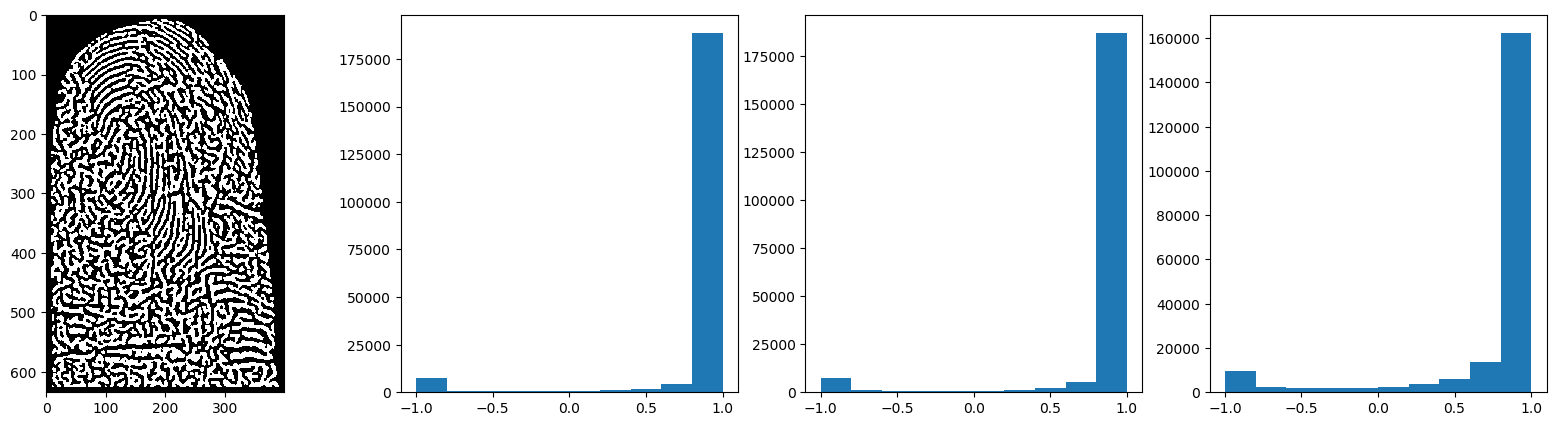

In [6]:
sp_17_33 = get_pair_scalar_product_distribution(prep_im, ksize=(17, 33))
sp_33_65 = get_pair_scalar_product_distribution(prep_im, ksize=(33, 65))
sp_17_65 = get_pair_scalar_product_distribution(prep_im, ksize=(17, 65))


fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 5))

ax0.imshow(prep_im, plt.cm.gray)
ax1.hist(sp_17_33.ravel())
ax2.hist(sp_33_65.ravel())
ax3.hist(sp_17_65.ravel())

plt.show()

## Perncentiles of pair scalar product

In [7]:
def get_pair_scalar_product_percentiles(im, ksize=(17, 65), ps=[5, 10, 20, 50]):
    pair_scalar_product = get_pair_scalar_product_distribution(im, ksize=ksize)
    percentiles = np.percentile(pair_scalar_product, ps)
    
    return percentiles

In [8]:
sp1 = get_pair_scalar_product_percentiles(prep_im, ksize=(17, 33))
sp2 = get_pair_scalar_product_percentiles(prep_im, ksize=(17, 65))
sp3 = get_pair_scalar_product_percentiles(prep_im, ksize=(33, 65))

sps = np.append([sp1, sp2], sp3)

sps

array([ 0.08772322,  0.85778122,  0.96073849,  0.99486368, -0.75434426,
        0.19873424,  0.77381932,  0.97555798,  0.05921495,  0.81843596,
        0.94888582,  0.99389432])

## Function for getting all percentiles

In [9]:
def get_all_pair_sp_percentiles(im, ksizes=(17, 33, 65), ps=[5, 10, 20, 50]):
    sp = np.array([])
    for ksize in comb(ksizes,  2):
        sp_ = get_pair_scalar_product_percentiles(im, ksize=ksize)
        sp = np.append(sp, sp_)
        
    return sp

In [10]:
sps = get_all_pair_sp_percentiles(prep_im)
sps

array([ 0.08772322,  0.85778122,  0.96073849,  0.99486368, -0.75434426,
        0.19873424,  0.77381932,  0.97555798,  0.05921495,  0.81843596,
        0.94888582,  0.99389432])

# Use Linear SVC for image classification

## Function for getting data

In [11]:
def get_xy_ims(filepath, images, x, y, y_val=1):
    
    for name in os.listdir(filepath):
        path = filepath + name
        im = cv.imread(path, cv.IMREAD_GRAYSCALE)
        
        if path == None:
            continue
        
        std_im = standardize_image(im)
        prep_im = preproc_image(std_im)
        percentiles = get_all_pair_sp_percentiles(prep_im)

        images.append(prep_im)
        x.append(percentiles)
        y.append(y_val)
    

## Get data

In [12]:
images, x, y = [], [], []


get_xy_ims(RAW_FILE_PATH_GOODIM, images, x, y)
get_xy_ims(RAW_FILE_PATH_BADIM_NOISE, images, x, y, y_val=0)

images = np.array(images)
x = np.array(x)
y = np.array(y)

DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,10,11
0,0.766618,0.969722,0.992937,0.999327,-0.839274,0.809345,0.970951,0.997856,0.890377,0.975081,0.994671,0.999503
1,0.845868,0.973198,0.993770,0.999332,-0.274245,0.880800,0.980203,0.998033,0.940090,0.988116,0.996517,0.999541
2,-0.090539,0.916672,0.981428,0.998088,-0.869876,0.191397,0.909839,0.993420,-0.041603,0.928463,0.985271,0.998560
3,0.851074,0.957054,0.988544,0.998917,0.547586,0.856767,0.964683,0.997021,0.938060,0.977985,0.993401,0.999384
4,0.882551,0.972340,0.992897,0.999289,0.148853,0.869741,0.975397,0.997911,0.922305,0.981320,0.995167,0.999557
...,...,...,...,...,...,...,...,...,...,...,...,...
81,-0.257156,0.806799,0.950560,0.993311,-0.816365,0.044542,0.706841,0.965018,-0.231354,0.747621,0.934043,0.991246
82,-0.446046,0.759218,0.941917,0.991803,-0.831740,-0.203809,0.621999,0.951371,-0.737936,0.591934,0.905430,0.986317
83,-0.206334,0.866894,0.961878,0.994208,-0.735751,0.108212,0.780696,0.973674,-0.118637,0.808698,0.945857,0.993507
84,0.627979,0.909155,0.972374,0.996247,-0.032624,0.588660,0.873133,0.985412,0.701400,0.913563,0.973390,0.996535


## Train LinearSVC and get

Является хорошим, считается плохим [-0.09053865  0.91667248  0.9814275   0.99808768 -0.86987625  0.1913974
  0.90983927  0.99342029 -0.04160259  0.92846282  0.98527089  0.99855988]


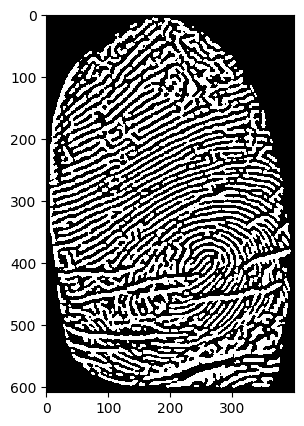

Является хорошим, считается плохим [-0.8025471   0.93673258  0.98728161  0.99888056 -0.96032982 -0.14502868
  0.93870904  0.99635737 -0.72399656  0.95731221  0.99129169  0.99917293]


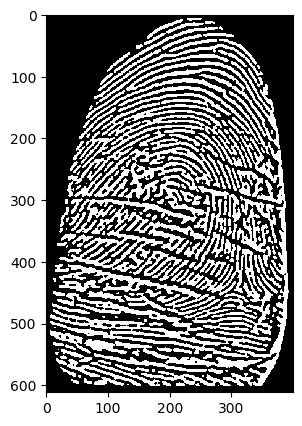

Является хорошим, считается плохим [-0.84758804  0.95645842  0.99008634  0.99891511 -0.95681986 -0.28587444
  0.95480552  0.99632232 -0.87405947  0.96457377  0.99173686  0.99913198]


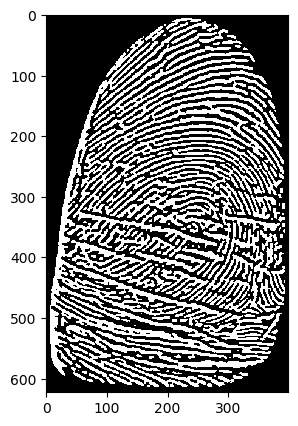

Является плохим, считается хорошим [0.78202768 0.92921077 0.97631143 0.99701699 0.35777941 0.73386261
 0.90808809 0.98902903 0.86905104 0.94763095 0.98068432 0.9974291 ]


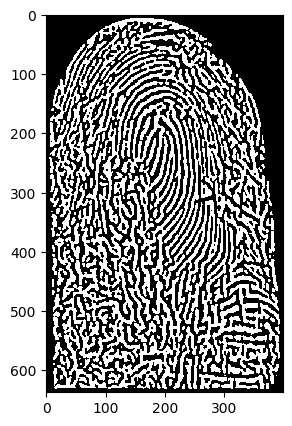

Является плохим, считается хорошим [0.74149483 0.92481863 0.97635877 0.99677216 0.30757553 0.71727937
 0.91434988 0.98918931 0.85838636 0.9516021  0.98421245 0.99762445]


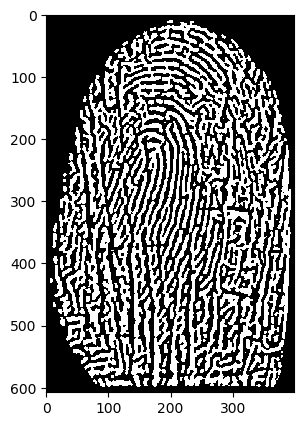

Является плохим, считается хорошим [ 0.62797914  0.90915487  0.97237415  0.99624743 -0.03262412  0.58865994
  0.87313285  0.98541229  0.70140011  0.91356327  0.97338989  0.99653543]


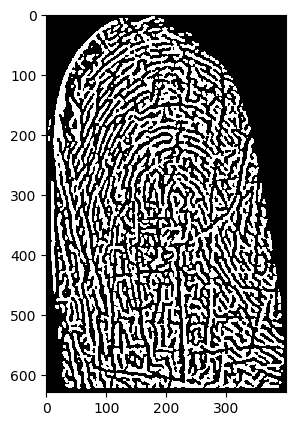

In [13]:
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score

svc = LinearSVC(max_iter=1000000)
svc.fit(x, y)

predict = svc.predict(x)
bool_predict = predict != y


for im, good, percs in zip(images[bool_predict], y[bool_predict], x[bool_predict]):
    
    if good:
        print("Является хорошим, считается плохим", percs)
    else:
        print("Является плохим, считается хорошим", percs)
    
    plt.imshow(im, cmap=plt.cm.gray)
    plt.show()

In [14]:
x = DataFrame(x)
x.corr(method='spearman')

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.000000,0.913220,0.876764,0.839195,0.834723,0.984037,0.904276,0.862405,0.970488,0.905936,0.871745,0.868386
1,0.913220,1.000000,0.989244,0.961714,0.644067,0.944015,0.992603,0.970130,0.919881,0.983735,0.977413,0.968884
2,0.876764,0.989244,1.000000,0.983150,0.572288,0.918296,0.992358,0.986452,0.892124,0.980772,0.989301,0.984055
3,0.839195,0.961714,0.983150,1.000000,0.509623,0.888048,0.972432,0.995075,0.861782,0.960431,0.981734,0.990848
4,0.834723,0.644067,0.572288,0.509623,1.000000,0.793966,0.627085,0.543267,0.807835,0.641879,0.566496,0.556589
5,0.984037,0.944015,0.918296,0.888048,0.793966,1.000000,0.944618,0.907955,0.990414,0.948675,0.919900,0.912918
6,0.904276,0.992603,0.992358,0.972432,0.627085,0.944618,1.000000,0.981678,0.925843,0.994886,0.989924,0.980282
7,0.862405,0.970130,0.986452,0.995075,0.543267,0.907955,0.981678,1.000000,0.884482,0.971564,0.988339,0.997736
8,0.970488,0.919881,0.892124,0.861782,0.807835,0.990414,0.925843,0.884482,1.000000,0.936240,0.899653,0.889633
9,0.905936,0.983735,0.980772,0.960431,0.641879,0.948675,0.994886,0.971564,0.936240,1.000000,0.986169,0.970526
